In [1]:
import pandas
import numpy
from sherpa.astro import ui as sherpa

from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from matplotlib.cm import get_cmap
cmap = get_cmap('viridis')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

%matplotlib inline

def get_order(X):
    
    X_order = numpy.zeros(X.shape[0])
    X_order[numpy.argsort(X)] = numpy.arange(X.shape[0])
    
    X_order = X_order.astype(float)
    X_order[numpy.isnan(X)] = numpy.nan
    X_order[X == 0] = numpy.nan
    
    return X_order

def reorder_spectra_mat(spectra_matrix, indecies_to_plot, order_by):
    nof_objects = len(indecies_to_plot)
    if len(order_by) > nof_objects:
        order_by = order_by[indecies_to_plot]
    order = numpy.argsort(order_by)
    spectra_matrix = spectra_matrix[indecies_to_plot]

    plot_matrix = spectra_matrix[order]
    return plot_matrix


def ladder_plot_smooth(CW, spectra_matrix, indecies_to_plot, order_by, nof_spectra, delta=1):
    plot_matrix = reorder_spectra_mat(spectra_matrix.copy(), indecies_to_plot, order_by)

    n_groups = nof_spectra
    l = int(len(indecies_to_plot) / n_groups) * n_groups
    groups = numpy.split(plot_matrix[:l], n_groups)
    plt.figure(figsize = (10,5))
    lw = 1
    stacked_spectra = numpy.zeros([n_groups, len(CW)])
    for g_idx, g in enumerate(groups):
        d = delta * g_idx
        x_plt = numpy.nanmedian(g, axis=0)
        stacked_spectra[g_idx] = x_plt
        plt.plot(CW, x_plt + d - numpy.nanmedian(x_plt), c=cmap(g_idx / (n_groups-1)), alpha = 0.9, lw = lw)
        plt.xlim([4730,5070])
        plt.xlabel(r'$\lambda [\AA]$', fontsize = 20)
        plt.ylabel('Normalized flux', fontsize = 20)
        plt.xticks([4750, 4850, 4950, 5050], fontsize = 20)
        plt.yticks([])
        plt.tight_layout()
        
    plt.show()
    return stacked_spectra

def print_sdss_link(plate, mjd, fiber):
    print('http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate={}&mjd={}&fiber={}'.format(plate, mjd, fiber))
    return

def fit_func(x,  A1, x1, sig1 ):
    #f(x) = ampl * exp(-4 * log(2) * (x - pos)^2 / fwhm^2)
    res = A1*numpy.exp(-4 * numpy.log(2) * (x-x1)**2 / (sig1**2) ) 

    return res



def powerlaw(x, ampl, ref, gamma):
    #f(x) = ampl * (x / ref)^(-gamma)

    res = ampl * (x / ref)**(-gamma)
    return res

In [2]:
hdul = fits.open('data/spiders_quasar_bhmass-DR14.fits')
data_tbl = Table(hdul[1].data)
spiders_df = data_tbl.to_pandas()
del(hdul)
del(data_tbl)
spiders_df.head()
spiders_BLAGN_df = spiders_df[ (spiders_df['CLASS_BEST'] == 'BLAGN ') | (spiders_df['CLASS_BEST'] == 'QSO   ')].copy()
del(spiders_df)
print(spiders_BLAGN_df.shape)
spiders_BLAGN_df.head()

(8302, 170)


,xray_detection,name,RA,DEC,ExpTime,ExiML_2RXS,DETML_XMMSL,f_2RXS,errf_2RXS,fden_2RXS,...,logBHMVP_hb,errlogBHMVP_hb,logBHMMD_hb,errlogBHMMD_hb,logBHMA_hb,errlogBHMA_hb,l_edd1,l_edd2,edd_ratio1,edd_ratio2
0,2RXS,2RXS J131703.4-021538,199.26434,-2.26066,273.859985,161.0,-99.0,8.035261e-12,7.752275e-13,2.811901e-30,...,6.778126,0.082026,6.288811,0.082846,6.717432,0.082175,NaN,7.799543e+44,NaN,0.006164
1,2RXS,2RXS J130358.4+534748,195.99369,53.79679,505.869995,273.0,-99.0,8.729714e-13,3.046346e-13,3.318945e-31,...,7.750659,0.060184,7.374837,0.060549,7.710600,0.060250,NaN,7.321536e+45,NaN,0.007065
2,2RXS,2RXS J160951.4+490216,242.46435,49.03793,535.039978,266.0,-99.0,1.409289e-12,3.086196e-13,5.069907e-31,...,6.893677,0.096619,6.542989,0.096997,6.858188,0.096688,NaN,1.017701e+45,NaN,0.086011
3,2RXS,2RXS J081517.7+460431,123.82380,46.07529,463.630005,61.0,-99.0,4.602566e-12,6.818868e-13,1.625549e-30,...,7.158066,0.110853,6.823838,0.111148,7.125570,0.110907,NaN,1.870724e+45,NaN,0.066039
4,2RXS,2RXS J160519.8+520726,241.33253,52.12398,547.679993,95.0,-99.0,8.669619e-13,2.706654e-13,3.243396e-31,...,7.229066,0.078857,6.829267,0.079705,7.184648,0.079011,NaN,2.202975e+45,NaN,0.014213


In [3]:
import prepro
hb_flux_ratio = numpy.load('hb_flux_ratio.npy')
wave, specs_hb_oiii = numpy.load('specs_hb_oiii_spiders.npy')
wave_cont_flux, cont_flux = numpy.load('cont_flux.npy')
cont_flux_hb_oiii = prepro.same_grid(wave, wave_cont_flux, cont_flux)
n_objects = specs_hb_oiii.shape[0]
print(specs_hb_oiii.shape)

Putting all spectra on the same grid with  lambda_max = 4600.25 and  lambda_min  = 5199.73
(8302, 533)


In [4]:
specs_hb_oiii_normed = specs_hb_oiii - cont_flux_hb_oiii    
    
specs_hb_oiii_normed_plot = specs_hb_oiii #-  cont_flux_hb_oiii
for i in range(n_objects):
    spec_norm = numpy.nansum(specs_hb_oiii_normed_plot[i,167:241])
    specs_hb_oiii_normed_plot[i] = (specs_hb_oiii_normed_plot[i] / spec_norm)

/Users/itamar/anaconda2/envs/avocado/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


6028


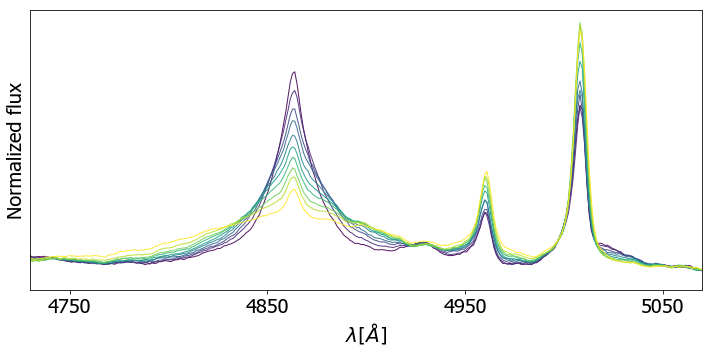

In [5]:
n_spectra = 10
inds = numpy.where(numpy.isfinite(hb_flux_ratio))[0]
print(len(inds))
stacked_spectra = ladder_plot_smooth(wave, specs_hb_oiii_normed_plot.copy(), inds, 1/hb_flux_ratio, n_spectra, delta=0)

# Fitting the stacked spectra

We will fit each of the stacked spectra with the following components:
1. Narrow lines - $H_{\beta}$, $O III \lambda 4963 $, $O III \lambda 5007$
2. Broad lines - $H_{\beta}$, $O III \lambda 4963 $, $O III \lambda 5007$
3. Another $H_{\beta}$ component to account for the asymmetry in this line
4. Power law for continuum radiation <br>

Notes: 
* We do not remove the continuum before doing this fit.
* All the components in (1) share the velocity offset and the FWHM.
* $O III \lambda 4963 $ and $O III \lambda 5007$ have the theoretical amplitude ratio of 1:3 in both broad and narrow components.
* $O III \lambda 4963 $ and $O III \lambda 5007$ narrow components share the velocity offset and FWHM.

## The results of the fit for all 10 stacked spectra are shown below

<img src="fit_plots/mc_fit_stacked_spectra_0.jpeg"  width="800">
<img src="fit_plots/mc_fit_stacked_spectra_1.jpeg"  width="800">
<img src="fit_plots/mc_fit_stacked_spectra_2.jpeg"  width="800">
<img src="fit_plots/mc_fit_stacked_spectra_3.jpeg"  width="800">
<img src="fit_plots/mc_fit_stacked_spectra_4.jpeg"  width="800">
<img src="fit_plots/mc_fit_stacked_spectra_5.jpeg"  width="800">
<img src="fit_plots/mc_fit_stacked_spectra_6.jpeg"  width="800">
<img src="fit_plots/mc_fit_stacked_spectra_7.jpeg"  width="800">
<img src="fit_plots/mc_fit_stacked_spectra_8.jpeg"  width="800">
<img src="fit_plots/mc_fit_stacked_spectra_9.jpeg"  width="800">


# Log($\frac{O III}{H_{\beta}}$) Vs. $H_{\beta}$ FWHM

From the results of the fit we calculate the narrow $O III$ and $H_{\beta}$ emisison lines ratio, and the width of the broad $H_{\beta}$. We expect a linear correlation between these two properties. This works nicely except the last two bins. Looking at the fits of these two bins, we see that the difference between them and the former bins is the lack of the asymetric $H_{\beta}$ component. This is either real or a bad fit. If this is a bad fit, the result of no asymetric $H_{\beta}$ component will result in a wider regular $H_{\beta}$ component. If this is the case than the $H_{\beta}$ FWHM is overestimated in the last two bins which could put them back on the line with the rest of the bins.

In [ ]:
[narrow_oiii_fwhm, narrow_oiii_ampl, narrow_h_beta_fwhm, narrow_h_beta_ampl, broad_h_beta_fwhm] = numpy.load('line_measurements.npy')

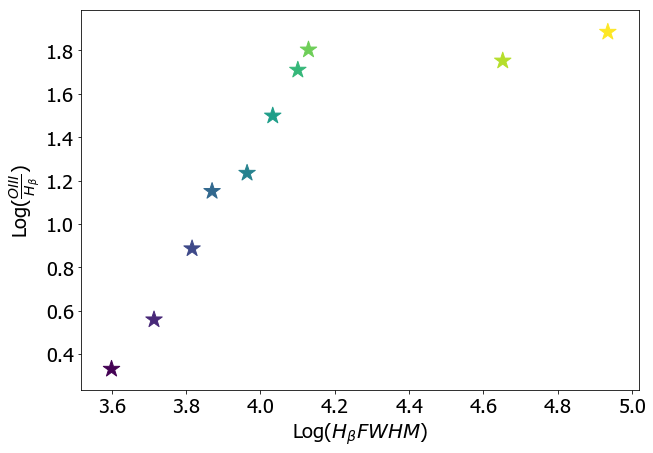

In [65]:
plt.figure(figsize = (10,7))
l_oiii = narrow_oiii_ampl*narrow_oiii_fwhm
l_hbeta = narrow_h_beta_ampl*narrow_h_beta_fwhm
plt.scatter(numpy.log(broad_h_beta_fwhm), numpy.log(l_oiii/l_hbeta), 
            marker = '*', s= 300, c = cmap(numpy.arange(n_spectra)/(n_spectra-1)))
plt.xlabel(r'Log($H_{\beta} FWHM$)', fontsize = 20)
plt.ylabel(r'Log($\frac{O III}{H_{\beta}}$)', fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.show()

# Code for the multy component fitting:

Dataset               = stacked_spectra_0
Method                = levmar
Statistic             = chi2
Initial fit statistic = 5.89311e+10
Final fit statistic   = 1.80421e+07 at function evaluation 201
Data points           = 261
Degrees of freedom    = 246
Probability [Q-value] = 0
Reduced statistic     = 73341.7
Change in statistic   = 5.89131e+10
   powlaw.gamma   1.05925      +/- 0.000618224 
   powlaw.ampl    0.840136     +/- 2.18413e-05 
   g_h_b.fwhm     7.86926      +/- 0.000972931 
   g_h_b.pos      4862.23      +/- 0.000353861 
   g_h_b.ampl     0.695305     +/- 0.000160533 
   g_oiii_1.ampl   0.322723     +/- 4.21124e-05 
   g_oiii_1_broad.fwhm   32.4475      +/- 0.00870958  
   g_oiii_1_broad.pos   4962.25      +/- 0.00334769  
   g_oiii_1_broad.ampl   0.0622364    +/- 2.32848e-05 
   g_h_b_broad.fwhm   36.6002      +/- 0.00286447  
   g_h_b_broad.pos   4863.55      +/- 0.00096961  
   g_h_b_broad.ampl   0.806279     +/- 7.75688e-05 
   g_h_b_asym.fwhm   36.6818      +/- 0.0

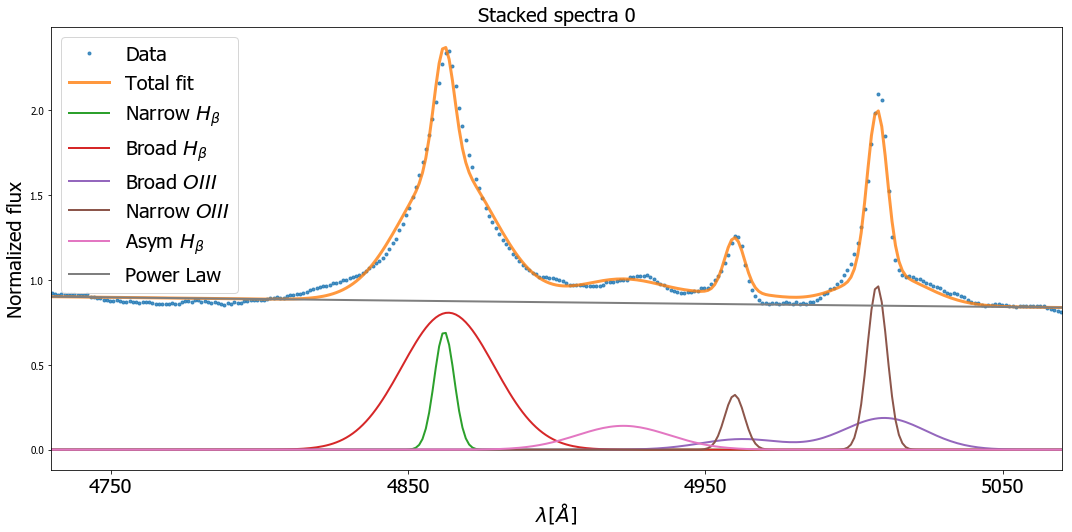

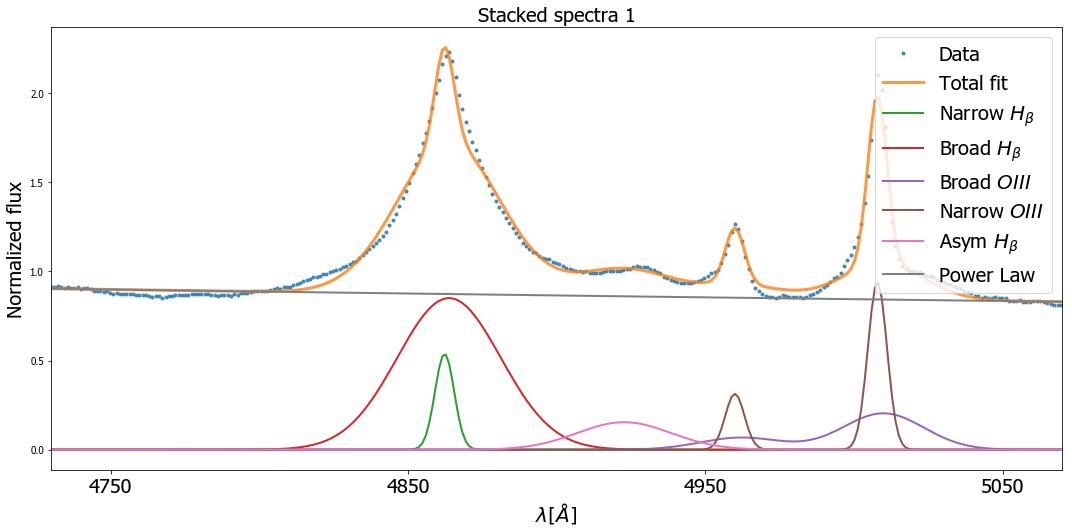

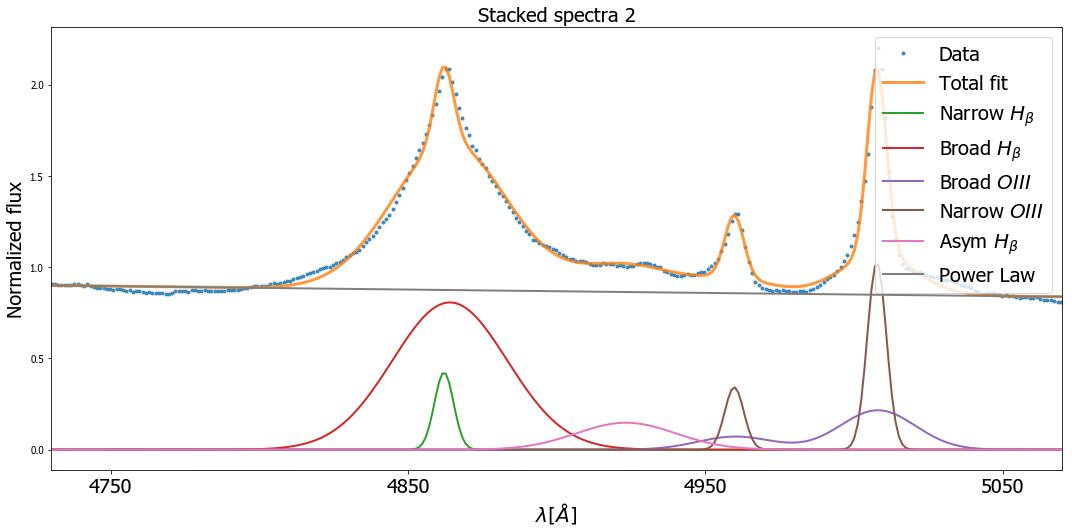

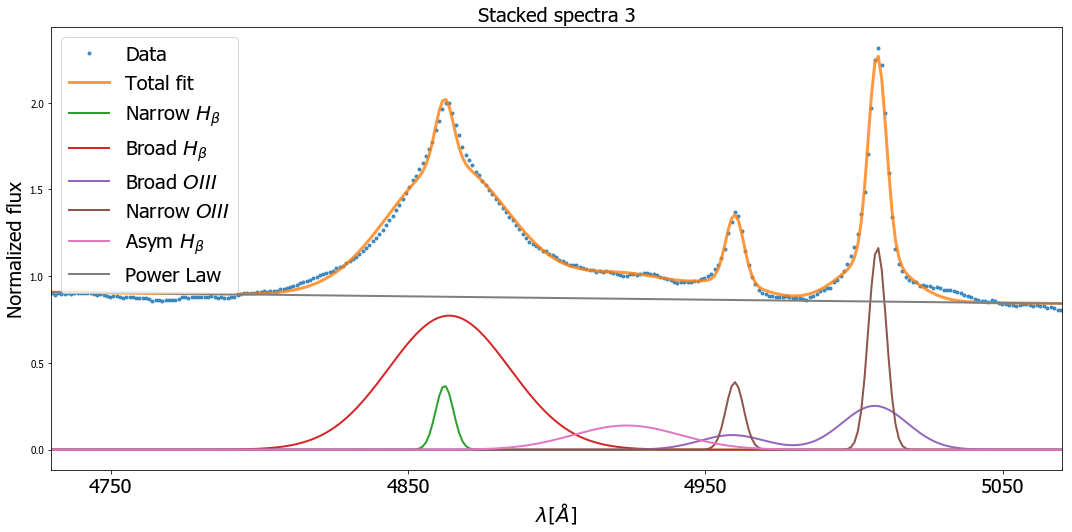

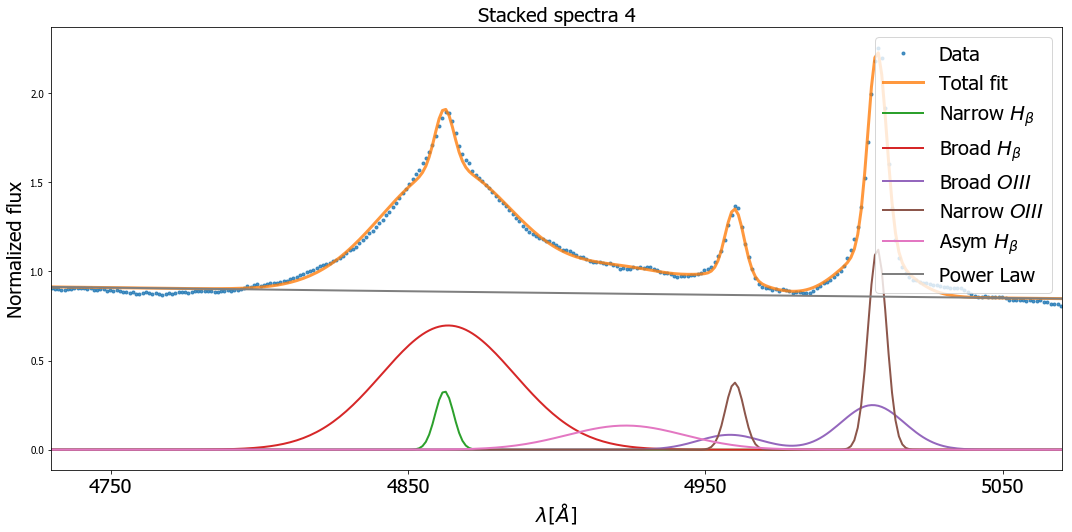

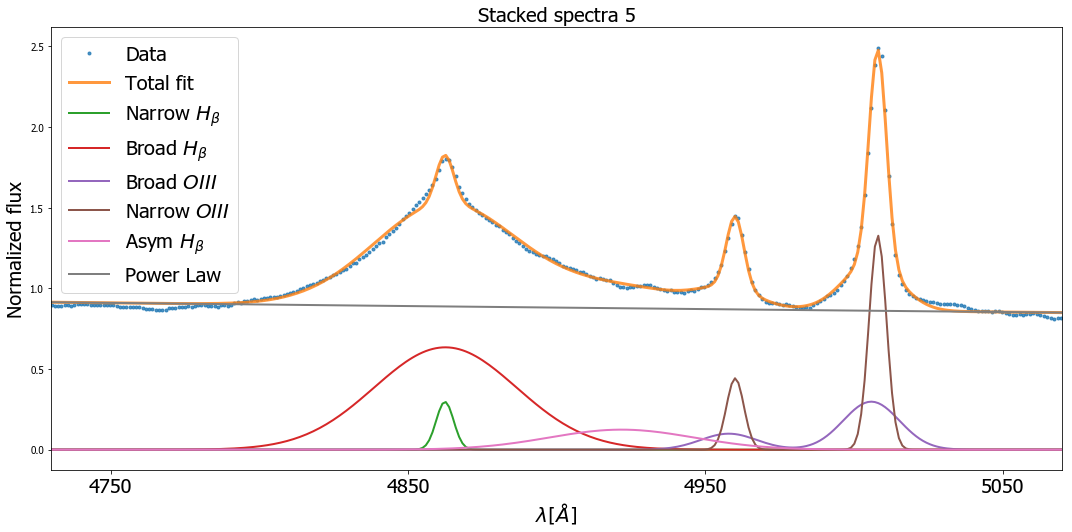

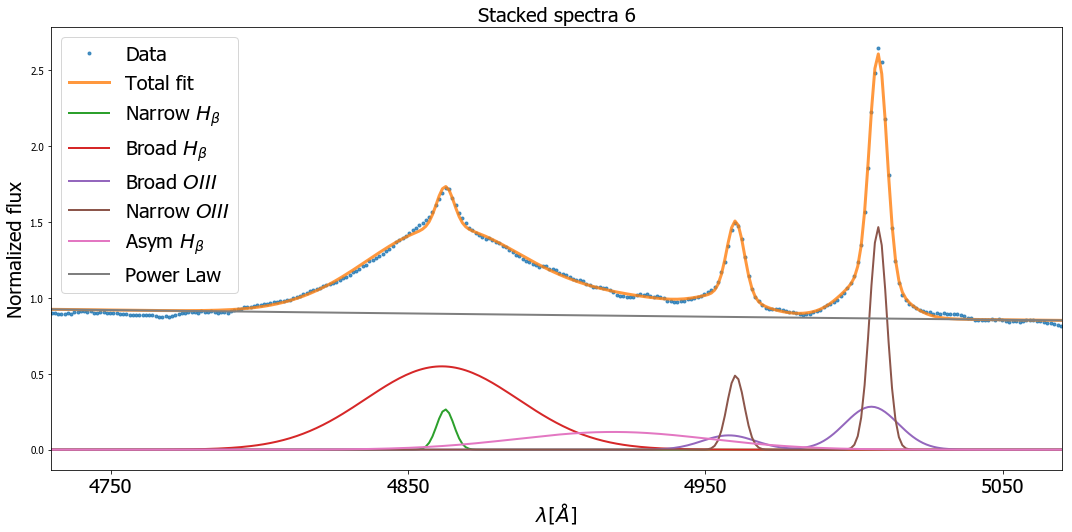

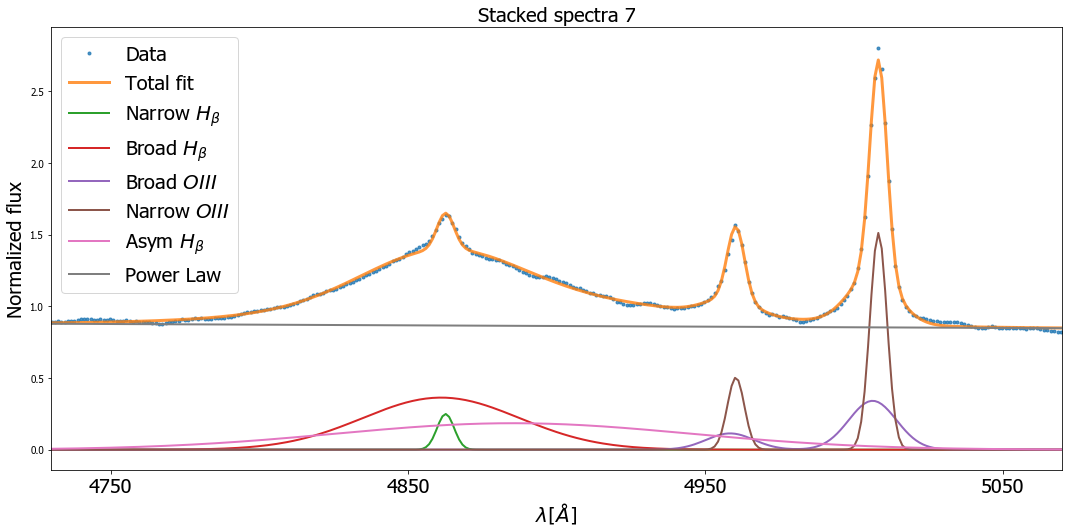

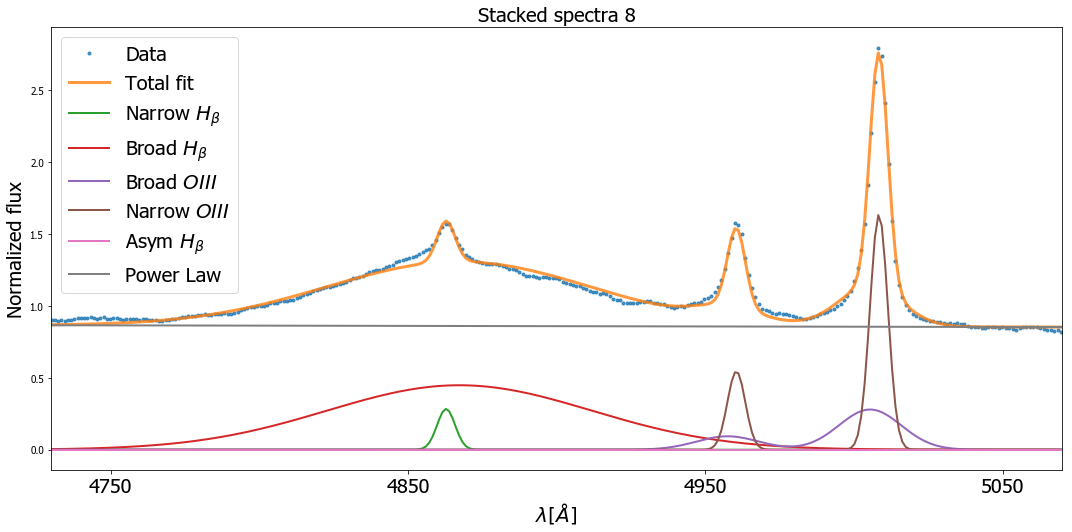

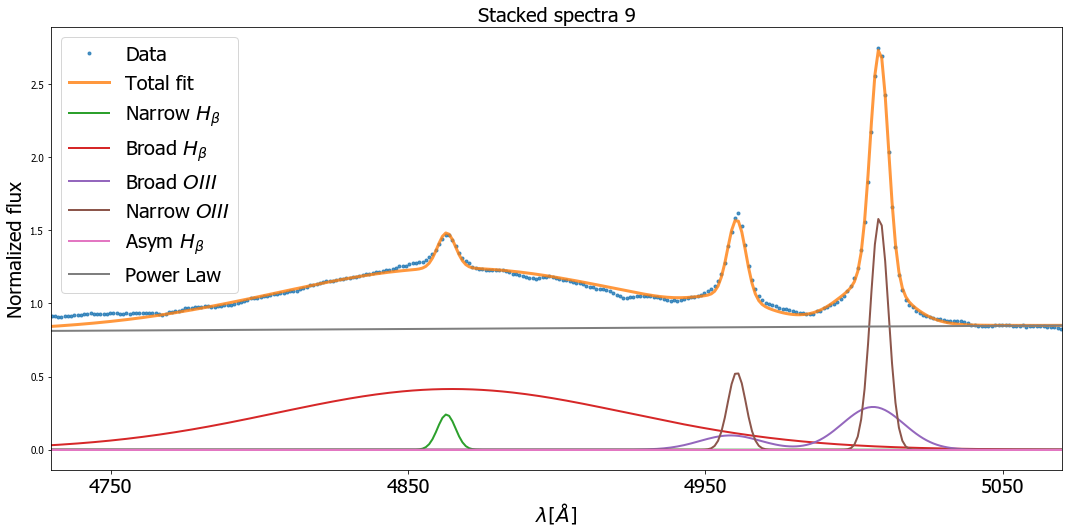

In [36]:
n_spectra = 10
narrow_oiii_fwhm = numpy.zeros(n_spectra)
narrow_oiii_ampl = numpy.zeros(n_spectra)

narrow_h_beta_fwhm = numpy.zeros(n_spectra)
narrow_h_beta_ampl = numpy.zeros(n_spectra)

broad_h_beta_fwhm = numpy.zeros(n_spectra)

for idx in range(n_spectra):
    model_str = 'stacked_spectra_{}'.format(idx)
    spectrum = stacked_spectra[idx].copy()
    sherpa.load_arrays(model_str, wave, spectrum, spectrum/100)

    s = 200
    e = 270
    hb_init_guess = wave[s:e][numpy.argmax(spectrum[s:e])]

    s = 350
    e = 380
    oiii_init_guess = wave[s:e][numpy.argmax(spectrum[s:e])]

    sherpa.create_model_component("gauss1d", "g_h_b_broad")
    sherpa.create_model_component("gauss1d", "g_h_b")
    sherpa.create_model_component("gauss1d", "g_oiii_1")
    sherpa.create_model_component("gauss1d", "g_oiii_2")
    sherpa.create_model_component("gauss1d", "g_oiii_1_broad")
    sherpa.create_model_component("gauss1d", "g_oiii_2_broad")
    sherpa.create_model_component("gauss1d", "g_h_b_asym")
    sherpa.create_model_component("powlaw1d", "powlaw")
    sherpa.set_source(model_str, powlaw+   g_h_b + g_oiii_1 + g_oiii_2 + g_oiii_1_broad + g_oiii_2_broad +  g_h_b_broad +g_h_b_asym)

    powlaw.ref = 5050
    powlaw.gamma.min = -5
    powlaw.gamma.max = 5

    # Initial Guess:
    g_h_b.pos = hb_init_guess
    g_oiii_1.pos = g_h_b.pos + (4960.295  - 4862.68)
    g_oiii_2.pos = g_h_b.pos + (5008.240  - 4862.68)
    g_h_b_broad.pos = hb_init_guess
    g_oiii_1_broad.pos = 4960.295
    g_oiii_2_broad.pos = g_oiii_1_broad.pos + (5008.240  - 4960.295 )
    g_h_b_asym.pos = 4910


    g_h_b.pos.max = 4866
    g_h_b.pos.min = 4858
    g_h_b_broad.pos.max = 4870
    g_h_b_broad.pos.min = 4855
    g_oiii_1_broad.pos.max = 4964+50
    g_oiii_1_broad.pos.min = 4955

    g_h_b.fwhm = 2
    g_oiii_1.fwhm = g_h_b.fwhm
    g_oiii_2.fwhm = g_h_b.fwhm
    g_h_b_broad.fwhm = 75
    g_oiii_1_broad.fwhm = 50
    g_oiii_2_broad.fwhm = g_oiii_1_broad.fwhm 
    g_h_b_asym.fwhm = 10


    g_h_b.ampl = 2
    g_oiii_1.ampl = 5
    g_oiii_2.ampl = 3*g_oiii_1.ampl
    g_h_b_broad.ampl = 4
    g_oiii_1_broad.ampl = 1
    g_oiii_2_broad.ampl = 3*g_oiii_1_broad.ampl
    g_h_b_asym.ampl = 2

    g_h_b.ampl.min = 0
    g_oiii_1.ampl.min = 0
    g_oiii_2.ampl.min = 0
    g_h_b_broad.ampl.min = 0
    g_oiii_1_broad.ampl.min = 0
    g_oiii_2_broad.ampl.min = 0
    g_h_b_asym.ampl.min = 0

    g_h_b.ampl.max = 15
    g_oiii_1.ampl.max = 15
    g_oiii_2.ampl.max = 15
    g_h_b_broad.ampl.max = 15
    g_oiii_1_broad.ampl.max = 15
    g_oiii_2_broad.ampl.max = 15
    g_h_b_broad.ampl.max = 15

    sherpa.set_model(model_str, sherpa.get_source(model_str))

    d1 = sherpa.get_data(model_str)
    d1.y *= 1/sherpa.get_data(model_str).y.mean()

    sherpa.notice(4775,5070)

    sherpa.fit(model_str)

    if False:
        plt.figure(figsize = (13,6))
        sherpa.plot_fit(model_str)
        sherpa.plot_model_component(model_str, g_oiii_1_broad, overplot=True)
        sherpa.plot_model_component(model_str, g_oiii_2_broad, overplot=True)
        sherpa.plot_model_component(model_str, g_oiii_1, overplot=True)
        sherpa.plot_model_component(model_str, g_oiii_2, overplot=True)

        sherpa.plot_model_component(model_str, g_h_b_broad, overplot=True)

        sherpa.plot_model_component(model_str, g_h_b, overplot=True)
        sherpa.plot_model_component(model_str, powlaw, overplot=True)
        sherpa.plot_model_component(model_str, g_h_b_asym, overplot=True)



        plt.show()
        

    narrow_oiii_fwhm[idx] = g_oiii_2.fwhm.val
    narrow_oiii_ampl[idx] = g_oiii_2.ampl.val
    narrow_h_beta_fwhm[idx] = g_h_b.fwhm.val
    narrow_h_beta_ampl[idx] = g_h_b.ampl.val
    broad_h_beta_fwhm[idx] = g_h_b_broad.fwhm.val

    ampl, ref, gamma = powlaw.ampl.val, powlaw.ref.val, powlaw.gamma.val
    plaw = powerlaw(wave, ampl, ref, gamma)

    A, pos, fwhm = g_h_b_broad.ampl.val, g_h_b_broad.pos.val, g_h_b_broad.fwhm.val#/2.355
    hb_broad = fit_func(wave, A, pos, fwhm)

    A, pos, fwhm = g_h_b_asym.ampl.val, g_h_b_asym.pos.val, g_h_b_asym.fwhm.val#/2.355
    hb_asym = fit_func(wave, A, pos, fwhm)

    A, pos, fwhm = g_h_b.ampl.val, g_h_b.pos.val, g_h_b.fwhm.val#/2.355
    hb_narrow = fit_func(wave, A, pos, fwhm)

    A, pos, fwhm = g_oiii_1_broad.ampl.val, g_oiii_1_broad.pos.val, g_oiii_1_broad.fwhm.val#/2.355
    g_oiii_broad = fit_func(wave, A, pos, fwhm)

    A, pos, fwhm = g_oiii_2_broad.ampl.val, g_oiii_2_broad.pos.val, g_oiii_2_broad.fwhm.val#/2.355
    g_oiii_broad = g_oiii_broad + fit_func(wave, A, pos, fwhm)


    A, pos, fwhm = g_oiii_1.ampl.val, g_oiii_1.pos.val, g_oiii_1.fwhm.val#/2.355
    g_oiii_narrow = fit_func(wave, A, pos, fwhm)

    A, pos, fwhm = g_oiii_2.ampl.val, g_oiii_2.pos.val, g_oiii_2.fwhm.val#/2.355
    g_oiii_narrow = g_oiii_narrow + fit_func(wave, A, pos, fwhm)



    plt.figure(figsize = (15,7.5))
    plt.title('Stacked spectra {}'.format(idx), fontsize = 20)

    plt.plot(wave, spectrum/numpy.mean(spectrum), '.', alpha = 0.8, label = 'Data')

    plt.plot(wave, g_oiii_narrow + g_oiii_broad + hb_broad + hb_narrow  + hb_asym + plaw, lw = 3, alpha = 0.8, label = 'Total fit')

    plt.plot(wave, hb_narrow, lw = 2, label = r'Narrow $H_{\beta}$')
    plt.plot(wave, hb_broad, lw = 2, label = r'Broad $H_{\beta}$')

    plt.plot(wave, g_oiii_broad, lw = 2, label = r'Broad $O {III}$')
    plt.plot(wave, g_oiii_narrow, lw = 2, label = r'Narrow $O {III}$')
    plt.plot(wave, hb_asym, lw = 2, alpha = 1, label = r'Asym $H_{\beta}$')
    plt.plot(wave, plaw, lw = 2, label = 'Power Law')



    plt.xlim([4730,5070])
    plt.xlabel(r'$\lambda [\AA]$', fontsize = 20)
    plt.ylabel('Normalized flux', fontsize = 20)
    plt.xticks([4750, 4850, 4950, 5050], fontsize = 20)
    #plt.yticks([])
    plt.legend(fontsize = 20)
    plt.tight_layout()
    plt.savefig('fit_plots/mc_fit_stacked_spectra_{}.jpeg'.format(idx))
    #plt.show()

In [45]:
numpy.save('line_measurements',[narrow_oiii_fwhm, narrow_oiii_ampl ,narrow_h_beta_fwhm, narrow_h_beta_ampl, broad_h_beta_fwhm] )